# Single Cell Sequencing: Control Atras and transferlabels


In [11]:
!pip install --quiet anndata
import os
import config as general_paths
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
#doublet detection
#batch correction (not installed by default in the docker container, install via command line: pip install scanorama bbknn)
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb
import sys 
sb.set_context(context='poster')
from matplotlib import rcParams
from datetime import date
today = date.today()
import seaborn as sns

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.24.3 scipy==1.11.1 pandas==1.5.3 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.11.6 louvain==0.8.2 pynndescent==0.5.12


In [12]:
figure_path = general_paths.figures_path
data_path = general_paths.data_path
output_path = general_paths.output_path
input_path = output_path
local_path = general_paths.local_path

In [13]:
adata = ad.read_h5ad(os.path.join(input_path , 'campari_scs_from_R.h5ad'))
adata_all = ad.read_h5ad(os.path.join(input_path , 'campari_scs_all_genes_from_R.h5ad'))


# List of genes to exclude
genes_to_exclude =  ['TdTomato','Cre','Campari','EGFP','mNeptune','ReachR','flp0','iCre','Calm1','rRNA_18s_1870bp'] 
# Filter the adata object to keep only the genes not in the exclusion list
adata = adata[:, ~adata.var_names.isin(genes_to_exclude)].copy()

print(adata.shape)

(4208, 15992)


In [14]:
x = adata.X
stim = np.zeros((x.shape[0],))
for i in range(x.shape[0]):
    stim[i] = adata.obs['stimulus'][i]
## We split the cels between campari and control cells
campari_cells = np.where(stim != 0)[0]
control_cells = np.where(stim == 0)[0]
print('Number of campari cells = ', len(campari_cells))
print('Number of control cells = ', len(control_cells))
adata_campari = adata[campari_cells,:]
adata_control = adata[control_cells,:]

adata_all_control = adata_all[control_cells,:]
adata_all_campari = adata_all[campari_cells,:]

Number of campari cells =  3089
Number of control cells =  1119


In [15]:
### Dimentionality reduction examples using multiple techniques
### Select one number of componets, for example n = 15 and do louvain in the umap transformation 
# with that number of componets
N_selected = 24
sc.pp.pca(adata_control, n_comps=N_selected, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_control)
sc.tl.tsne(adata_control)
sc.tl.umap(adata_control)

computing PCA
    with n_comps=24
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 24
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 24
    using sklearn.manifold.TSNE


/home/melma31/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


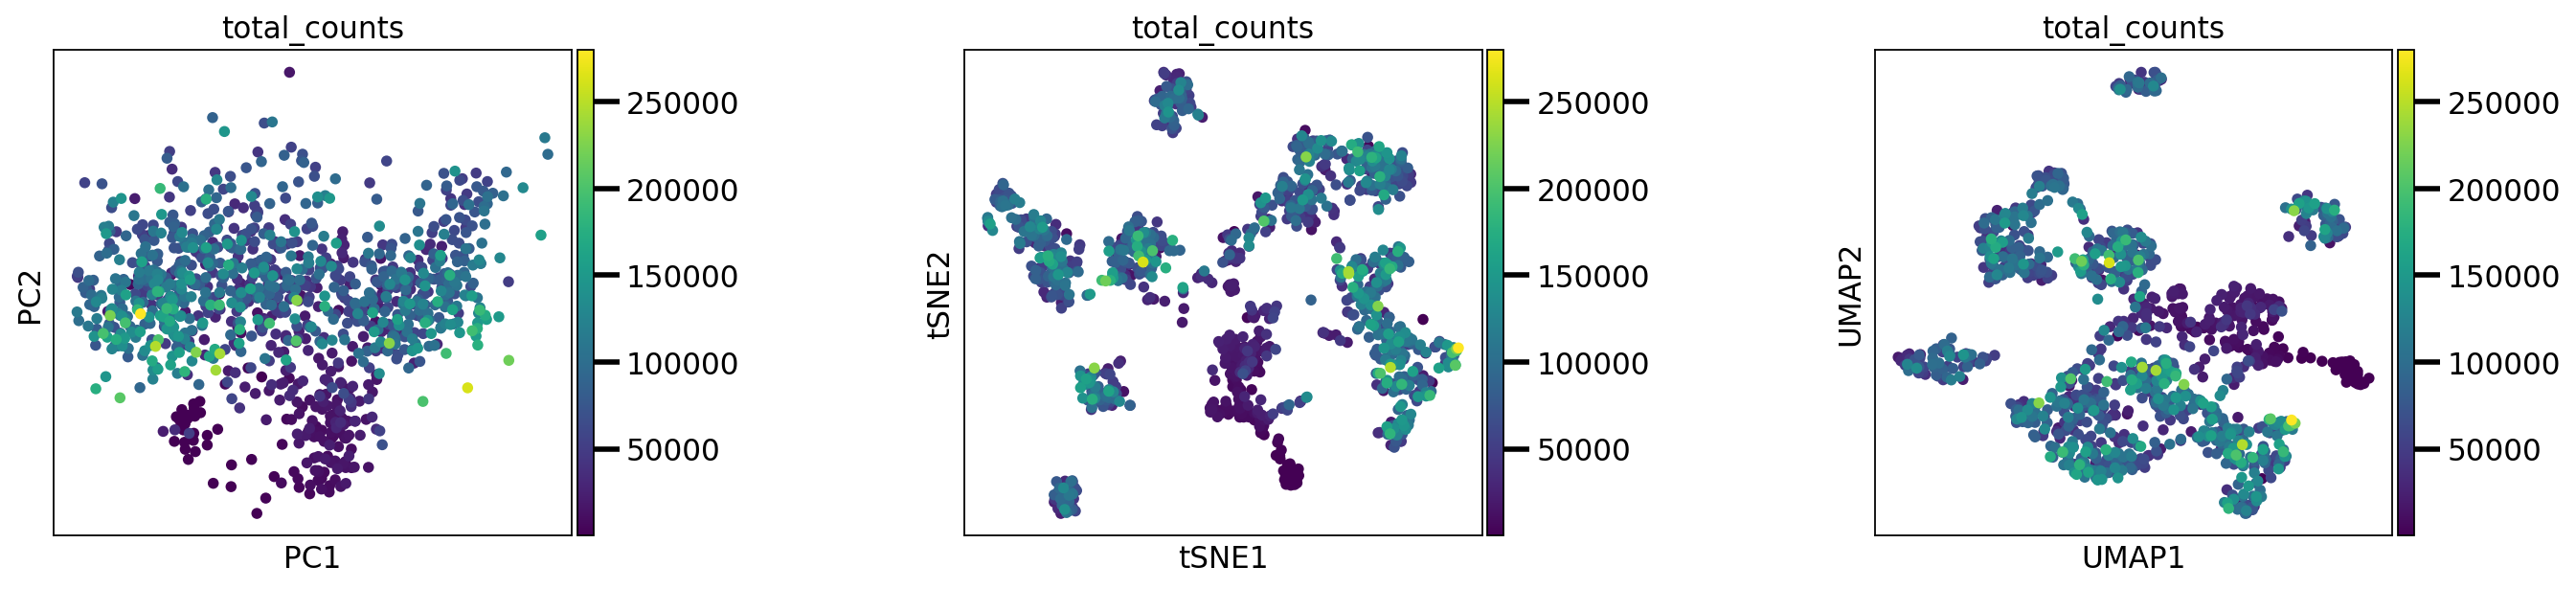

In [16]:
from matplotlib import rcParams

rcParams['figure.figsize']=(20,10)
fig_ind=np.arange(231, 237)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p10 = sc.pl.pca_scatter(adata_control, color='total_counts', ax=fig.add_subplot(fig_ind[0]), show=False)
p11 = sc.pl.tsne(adata_control, color='total_counts', ax=fig.add_subplot(fig_ind[1]), show=False)
p12 = sc.pl.umap(adata_control, color='total_counts', ax=fig.add_subplot(fig_ind[2]), show=False)

In [17]:
# Perform clustering - using highly variable genes ### maybe change to Leiden
louvain_paramenters = [0.3,0.5,1,1.5,2,2.5,3,3.5,4,4.5,6]
louvain_names = []
for value in louvain_paramenters:
    louvain_names.append('louvain_r' + str(value))

for value,name in zip(louvain_paramenters,louvain_names):
    sc.tl.louvain(adata_control, resolution=value, key_added=name)  

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain_r0.3', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain_r1.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain_r2', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain"

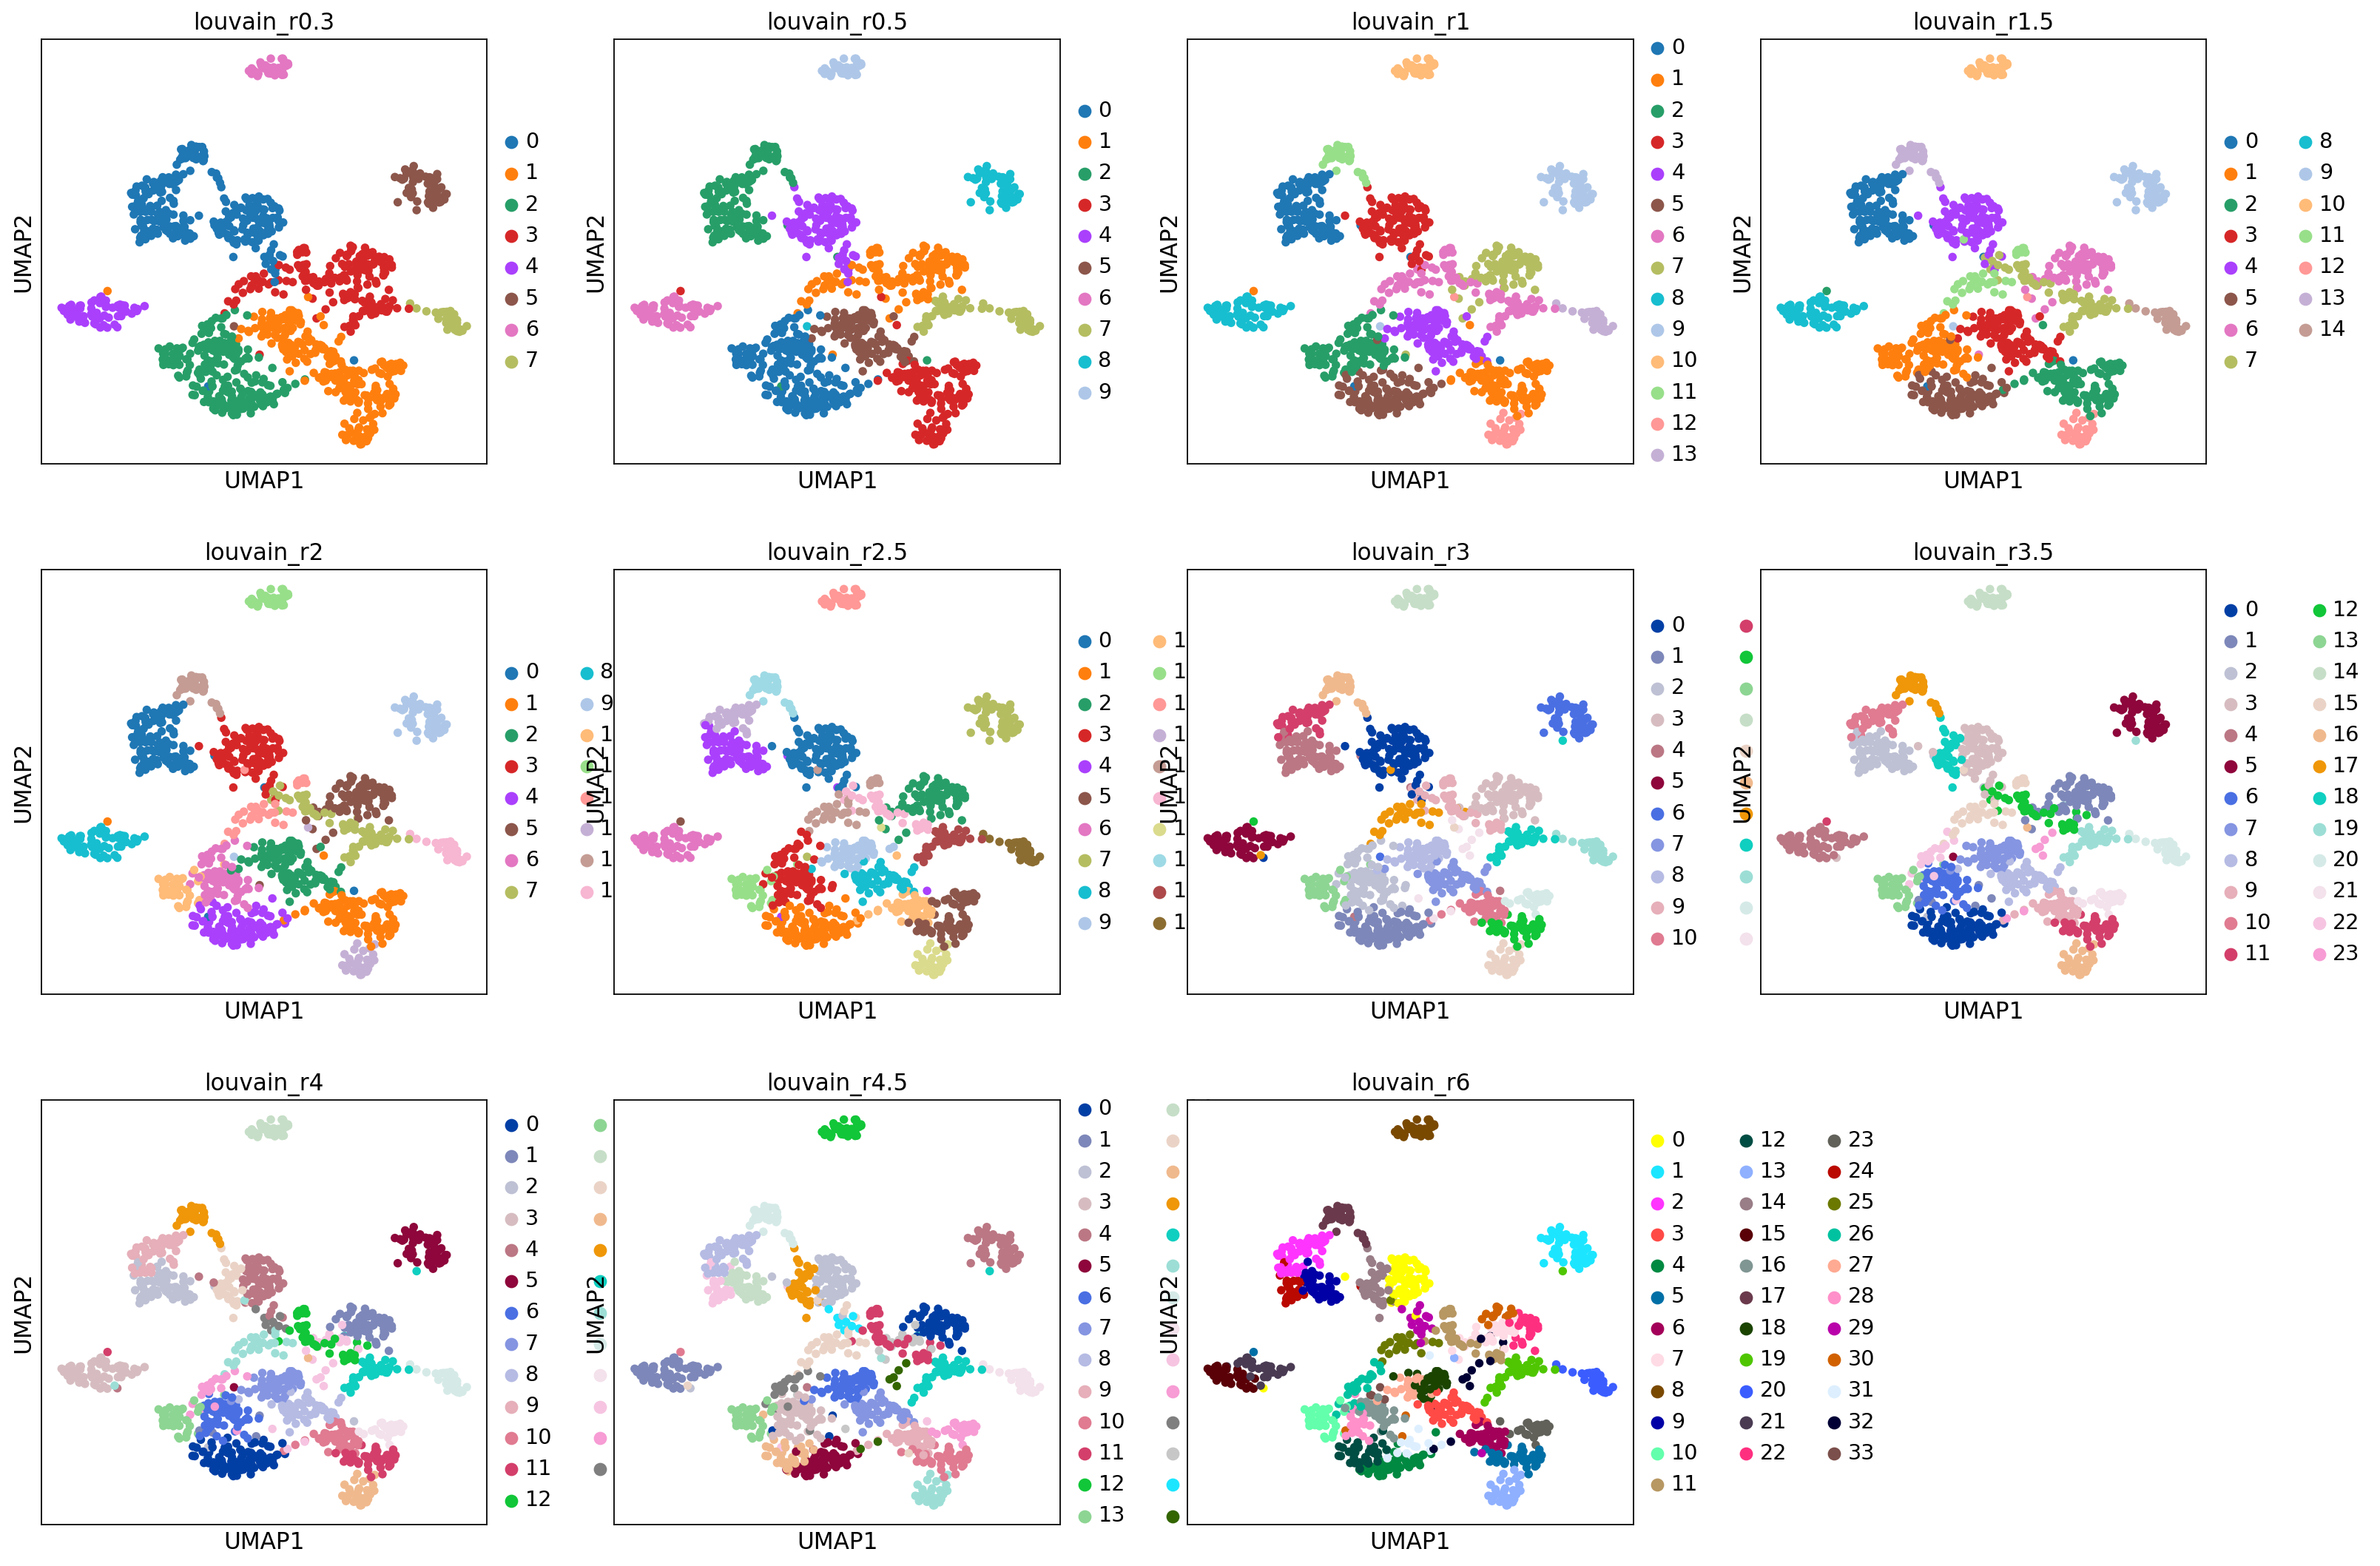

In [18]:
rcParams['figure.figsize']=(5,5)
#Visualize the clustering and how this is reflected by different technical covariates
#for name in louvain_names:
sc.pl.umap(adata_control, color=louvain_names, save = 'UMIs/louvain/'+name + 'control_atlas_from_R.png')
#sc.pl.umap(adata, color=['log_counts','stimuli'])

In [19]:
for clustering_method in louvain_names:
    sc.tl.ingest(adata_campari, adata_control, obs=clustering_method, embedding_method='umap')
    adata_campari.obs['transfered_clusters'] = adata_campari.obs[clustering_method]
    adata_control.obs['clusters'] = adata_control.obs[clustering_method]
    adata_concat = adata_control.concatenate(adata_campari, batch_categories=["control", "campari"])
    adata_all_concat = adata_all_control.concatenate(adata_all_campari, batch_categories=["control", "campari"])
    
    

running ingest


/home/melma31/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


    finished (0:00:04)


<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['rep']` of view, initializing view as actual.
<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.


running ingest


/home/melma31/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


    finished (0:00:04)
running ingest


/home/melma31/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


    finished (0:00:04)
running ingest


/home/melma31/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


    finished (0:00:04)
running ingest


/home/melma31/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


    finished (0:00:04)
running ingest


/home/melma31/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


    finished (0:00:04)
running ingest


/home/melma31/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


    finished (0:00:04)
running ingest


/home/melma31/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


    finished (0:00:04)
running ingest


/home/melma31/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


    finished (0:00:04)
running ingest


/home/melma31/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


    finished (0:00:04)
running ingest


/home/melma31/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


    finished (0:00:04)


In [20]:
### create and exportable varable list of genes names
gene_name = []
for i in range(len(adata_concat.var['gene_name'])):
    gene_name.append(adata_concat.var['gene_name'].iloc[i])
    
gene_name_all = []
for i in range(len(adata_all_concat.var['gene_name'])):
    gene_name_all.append(adata_all_concat.var['gene_name'].iloc[i])
### transform adata sparse matrix to scipy
x_all = adata_all_concat.X
x = adata_concat.X
### create exportable arrays with information about stimuli, fluorecence, and louvain transformations
stim = np.zeros((x.shape[0],))
red = np.zeros((x.shape[0],))
green = np.zeros((x.shape[0],))
cell_id = np.zeros((x.shape[0],))
plate_number = np.zeros((x.shape[0],))

louvain = np.zeros((x.shape[0],len(louvain_names)))
for i in range(x.shape[0]):
    stim[i] = adata_concat.obs['stimulus'][i]
    red[i] = adata_concat.obs['red'][i]
    green[i] = adata_concat.obs['green'][i]
    plate_number[i] = adata_concat.obs['plate_number'][i]
    #cell_id[i] = adata.obs['cell_id'][i]
    count = 0
    for name in louvain_names:
        louvain[i,count] = adata_concat.obs[name][i]
        count = count + 1
        
data = {'umap': adata_concat.obsm['X_umap'],'gene_name' : np.array(gene_name_all),'gene_name_matrix' : np.array(gene_name),
        'sparse_matrix': x_all,'matrix': x,'stimuli':stim,
        'red_intesity': red, 'green_intensity': green, 'louvain' : louvain, 'louvain_name': louvain_names, 'cell_id': cell_id, 'plate_number': plate_number}

scipy.io.savemat(os.path.join(input_path , 'umap_control_embedding_date_'+str(today)+'.mat'), data) ### os.join path  + time so no manual!

#################################################################################
#################################################################################
#################################################################################

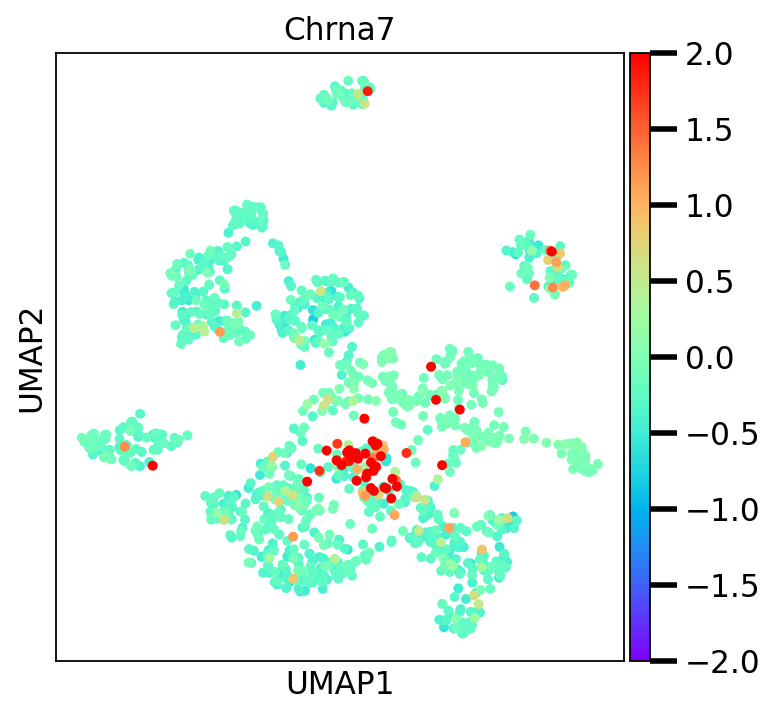

In [21]:
marker_genes = ['Krt79','Trpm3','Piezo2','Trpm2','Smr2','Sstr2','Bmpr1b','Trpm8','Trpv1','Piezo2','Piezo1','Nppb',
                'Sst','Pvalb','Prokr2','Mrgprd','Mrgpra3','Cd34',
                'Th','Trpa1','Ntrk3','Ntrk2','Ntrk1','Ret','Tac1','Calca','Calcb','Nefh',
                'S100b','Scn10a','Slc17a8','Atf3','Pou4f3','Calb1','Calb2','Avil','Asic3',
                'Asic2','Asic1','Pou6f2','Avpr1a','Pou4f2','Sox10','Casq2','Chrna7','Chrna3',
                'P2rx3','Ldhb','Necab2','Spp1','Adm','Hpse','Adra2a','Rbfox3']
marker_genes = ['Chrna7']
sc.pl.umap(adata=adata_control, color=marker_genes, use_raw=False, cmap = 'rainbow',save = 'UMIs/expression/genes_control_cells_marker_genes' + '.png',
           size = 80,vmin=-2, vmax=2)

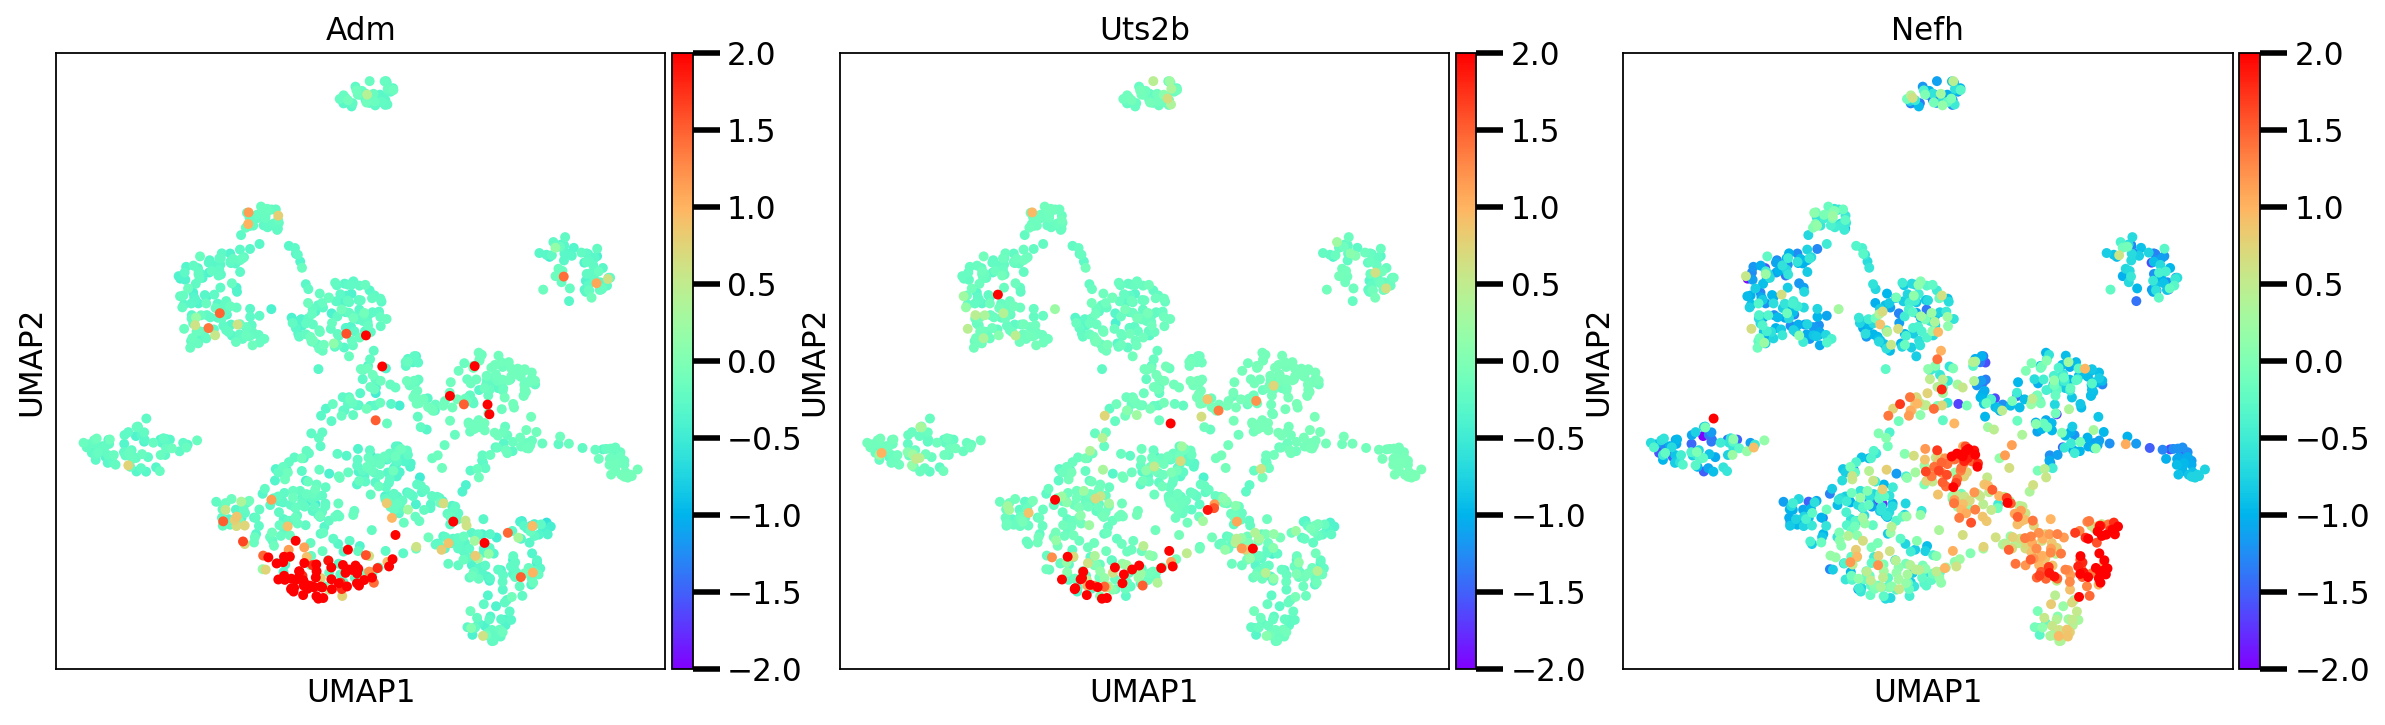

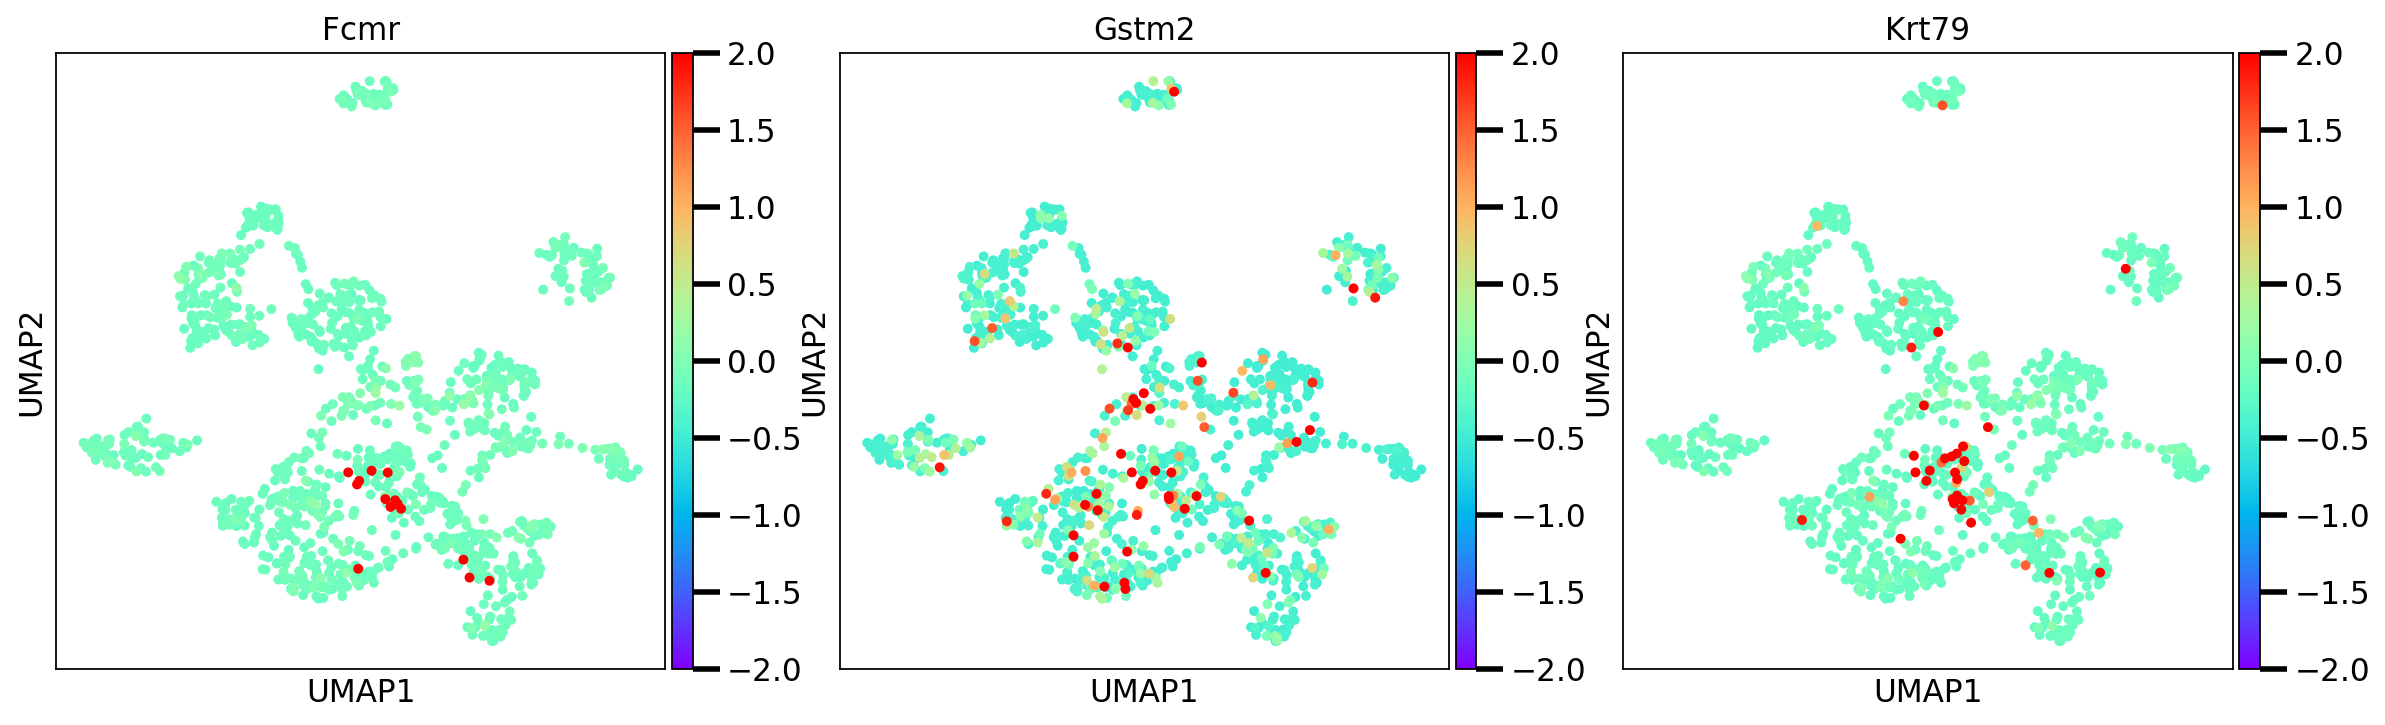

In [35]:
#rcParams['figure.figsize']=(5,5)
#marker_genes = ['Adm','Uts2b','Nefh']
#sc.pl.umap(adata=adata_control, color=marker_genes, use_raw=False, cmap = 'rainbow',save = 'UMIs/expression/genes_control_cells_marker_Adm_' + '.png',
#           size = 80,vmin=-2, vmax=2)
#marker_genes = ['Fcmr','Gstm2','Krt79']
#sc.pl.umap(adata=adata_control, color=marker_genes, use_raw=False, cmap = 'rainbow',save = 'UMIs/expression/genes_control_cells_marker_Adm_' + '.png',
#           size = 80,vmin=-2, vmax=2)

Text(0, 0.5, 'UMAP2')

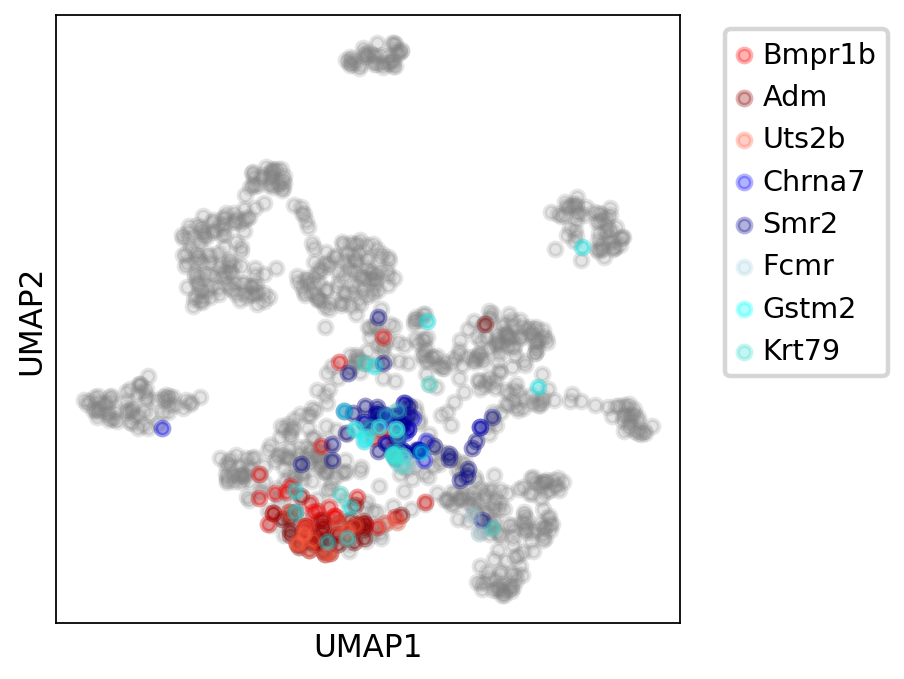

In [36]:
# show selected genes on same umap (each gene, different color)
genes2show = ['Bmpr1b','Adm','Uts2b','Chrna7','Smr2','Fcmr','Gstm2','Krt79']
# select colors for those genes
my_colors = ['r','darkred','tomato','b','darkblue','lightblue','cyan','turquoise']
# select thresholds values for those genes (above which value to show them)
threshold = 3# show selected genes on same umap (each gene, different color)

figure, axes = plt.subplots()
# show umap as gray alpha dots
axes.scatter(adata_control.obsm['X_umap'][:,0],adata_control.obsm['X_umap'][:,1],c='gray',alpha=0.2)
for i in range(len(genes2show)):
    # normalized values for each gene at each point of umap representation
    my_gene_values = adata_control.obs_vector(genes2show[i])
    # select which to show (use threshold)
    my_gene_indexes_above_threshold = np.where(my_gene_values > threshold)[0]
    axes.scatter(adata_control.obsm['X_umap'][my_gene_indexes_above_threshold,0],adata_control.obsm['X_umap'][my_gene_indexes_above_threshold,1],c=my_colors[i],alpha=0.3,label=genes2show[i])
axes.grid(False)
axes.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
figure.set_size_inches([5,5])    
# Hide X and Y axes tick marks
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('UMAP1')
axes.set_ylabel('UMAP2')
#fig_title = fig_title+"above_"+str(threshold)
#figure.savefig(os.path.join(figure_path, fig_title+'.png'))

## We choose a clustering method

Here we choose a Louvain order, and we run ingestion with campari cells and we quantify the stimuli.

In [22]:
clustering_method = 'louvain_r2'

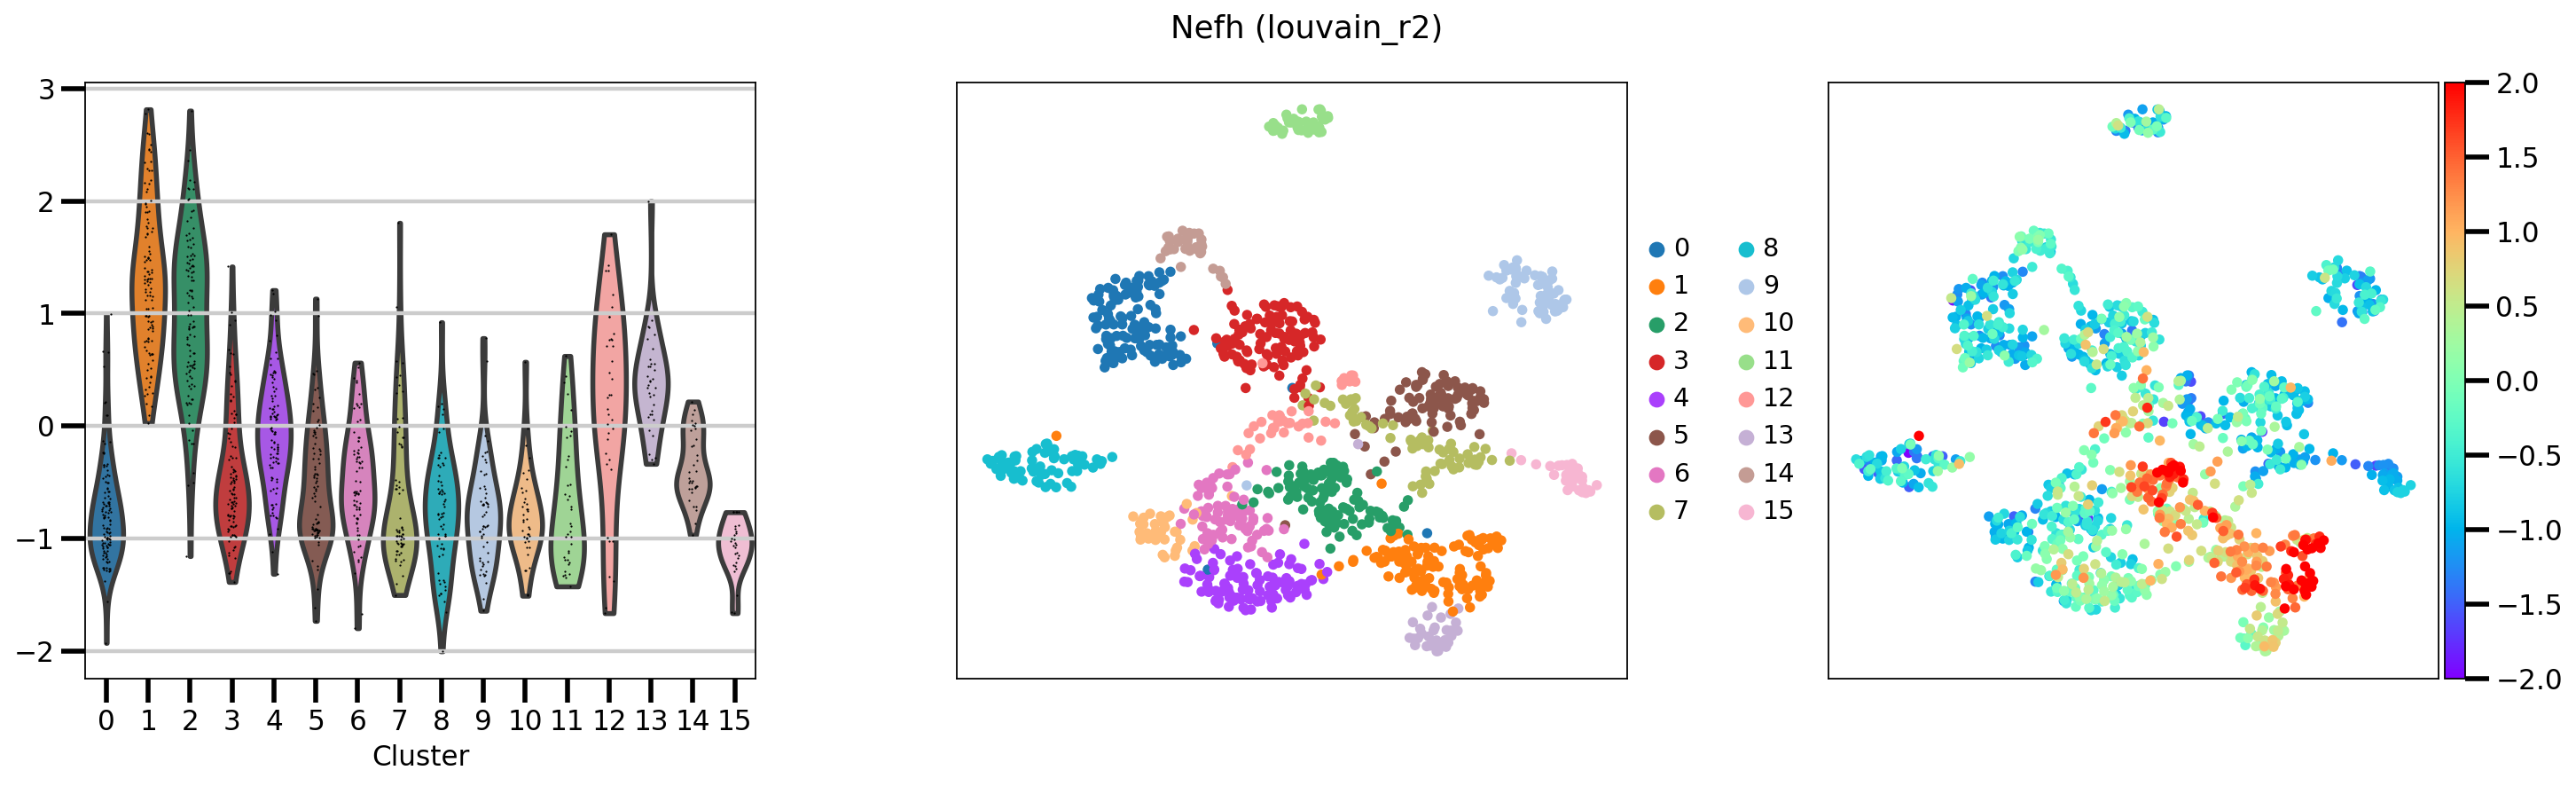

In [23]:
# for each gene, show 3 plots next to each other:
# 1) gene value distribution in each cluster (violin plot)
# 2) umap plot with clusters (to see where each cluster number is)
# 3) umap plot with gene value distribution in each cluster (values to colormap)
MY_LEFT = 0.09
MY_RIGHT = 0.9
MY_TOP = 0.9
MY_BOTTOM = 0.2
MY_WSPACE = 0.3
MY_HSPACE = 0.5
# Show violin plots next to clasters
# compare a certain gene across clasters
marker_genes = ['Krt79','Trpm3','Piezo2','Trpm2','Smr2','Sstr2','Bmpr1b','Trpm8','Trpv1','Piezo2','Piezo1','Nppb',
                'Sst','Pvalb','Prokr2','Mrgprd','Mrgpra3','Cd34',
                'Th','Trpa1','Ntrk3','Ntrk2','Ntrk1','Ret','Tac1','Calca','Calcb','Nefh',
                'S100b','Scn10a','Slc17a8','Atf3','Pou4f3','Calb1','Calb2','Avil','Asic3',
                'Asic2','Asic1','Pou6f2','Avpr1a','Pou4f2','Sox10','Casq2','Chrna7','Chrna3',
                'P2rx3','Ldhb','Necab2','Spp1','Adm','Hpse','Adra2a','Rbfox3']

marker_genes = ['Nefh']
for gene in marker_genes:
    # This produces two Axes objects in a single Figure
    ncols=3
    nrows=1
    figsize=5
    wspace=0.2
    fig,ax = plt.subplots(nrows=nrows, ncols=ncols,
                        figsize=(ncols*figsize+figsize*wspace*(ncols-1)+4,nrows*figsize+1))
    plt.subplots_adjust(left=MY_LEFT, 
                    bottom=MY_BOTTOM,  
                    right=MY_RIGHT,  
                    top=MY_TOP,  
                    wspace=MY_WSPACE,  
                    hspace=MY_HSPACE)
    fig.suptitle(gene+' ('+clustering_method+')\n', fontsize=16)
    # We can use these Axes objects individually to plot on them
    # We need to set show=False so that the Figure is not displayed before we
    # finished plotting on all Axes and making all plot adjustments
    sc.pl.violin(adata_control, gene, use_raw=False, groupby=clustering_method,xlabel='Claster', ylabel='',ax=ax[0],show=False)
    ax[0].set_xlabel("Cluster") # change x label from louvain to claster
    ax[0].set_ylabel("")
    sc.pl.umap(adata_control, color=clustering_method, use_raw=False, title='', ax=ax[1],show=False)
    ax[1].set_xlabel("")
    ax[1].set_ylabel("")
    sc.pl.umap(adata_control, color=gene, use_raw=False, cmap = 'rainbow',title='', ax=ax[2],show=False,vmin=-2, vmax=2)
    ax[2].set_xlabel("")
    ax[2].set_ylabel("")
    ax[2].set_xticks([])
    ax[2].set_yticks([]) 
    plt.show()
    fig.savefig(os.path.join(figure_path , 'violin_'+gene+'_'+clustering_method+'.png'))

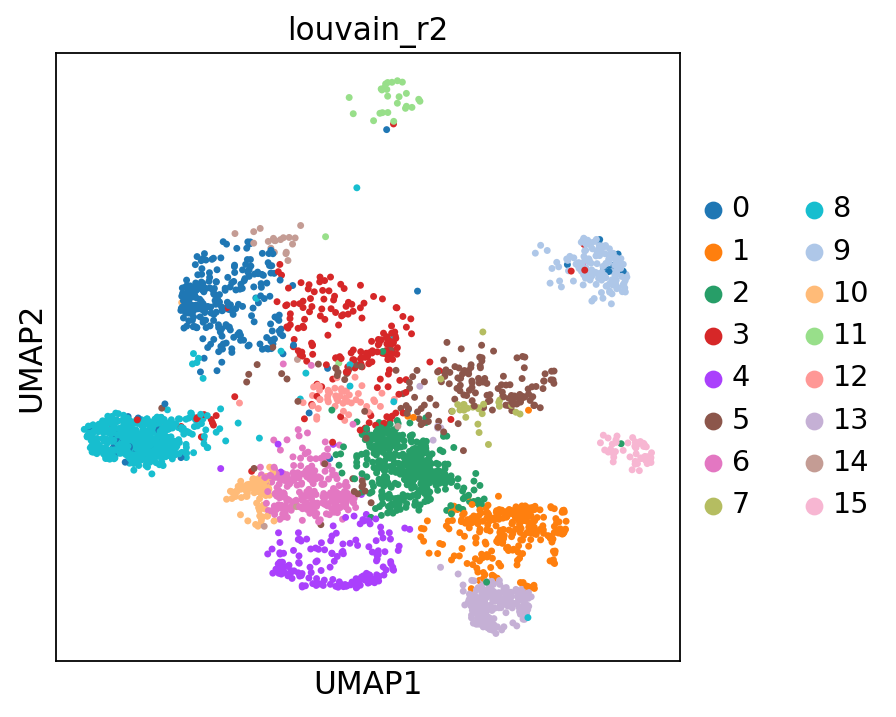

In [24]:
sc.pl.umap(adata_campari, color=[clustering_method], wspace=0.3)
adata_campari.obs['transfered_clusters'] = adata_campari.obs[clustering_method]
adata_control.obs['clusters'] = adata_control.obs[clustering_method]

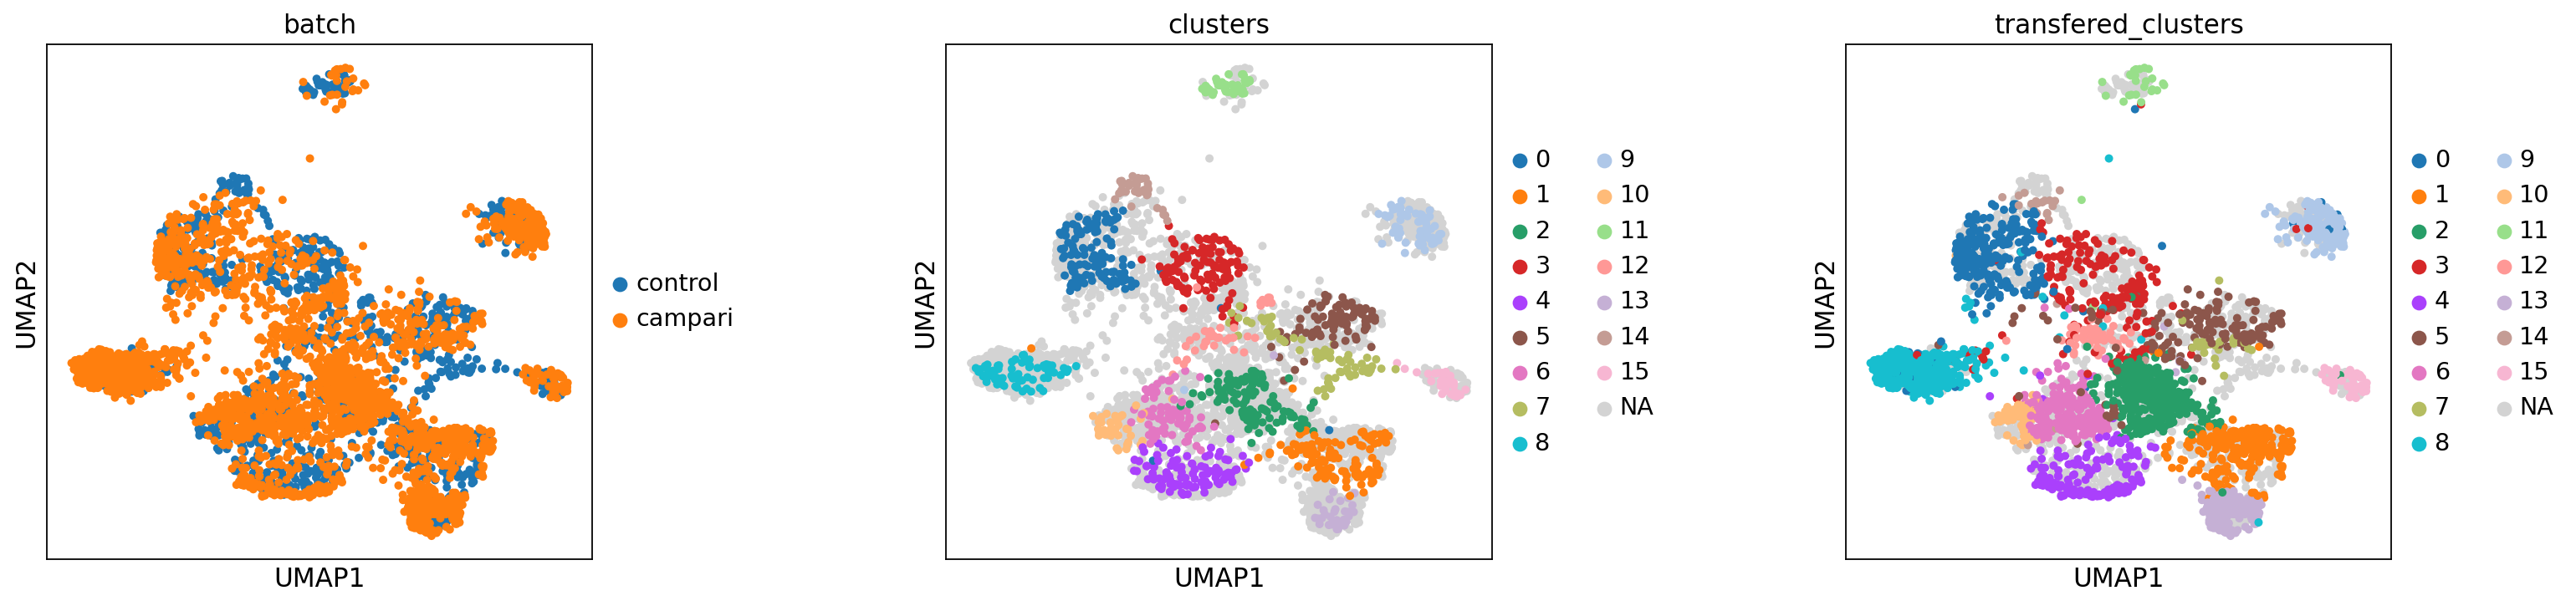

In [25]:
adata_concat = adata_control.concatenate(adata_campari, batch_categories=["control", "campari"])
adata_all_concat = adata_all_control.concatenate(adata_all_campari, batch_categories=["control", "campari"])

# fix category ordering
#adata_concat.obs.louvain.cat.reorder_categories(
#    adata_human.obs.louvain.cat.categories, inplace=True
#)
# fix category colors
sc.pl.umap(adata_concat, color=["batch", 'clusters',"transfered_clusters"], wspace = 0.5,save = 'UMIs/integration_control_campari.png', size = 80,
              vmin=-2, vmax=2)

In [2]:
#gene = 'EGFP'
#index = 0
#for  i in range(len(adata_all_concat.var['gene_name'])):
#    if adata_all_concat.var['gene_name'][i] == gene:
#        index = i
#print(index)

In [1]:
#stim = 24
#gene = 'Avil'

#selected_stim = np.ones((adata_concat.shape[0],))*0
#index = 0
#for  i in range(len(adata_concat.var['gene_name'])):
#    if adata_concat.var['gene_name'][i] == gene:
#        index = i
#print(index)
#selected_stim[np.where(adata_concat.obs['stimulus'] == stim)[0]] = adata_concat.X[np.where(adata_concat.obs['stimulus'] == stim)[0],index]
#adata_concat.obs['stimulus_selected'] = selected_stim
#
#sc.pl.umap(adata_concat, color=['batch',gene, 'stimulus_selected'], title=['Batch','Gene','Stim'],
#            wspace = 0.5,save = 'UMIs/integration_campari_stimuli.png', size = 80, cmap = 'rainbow')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:14)


/home/melma31/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


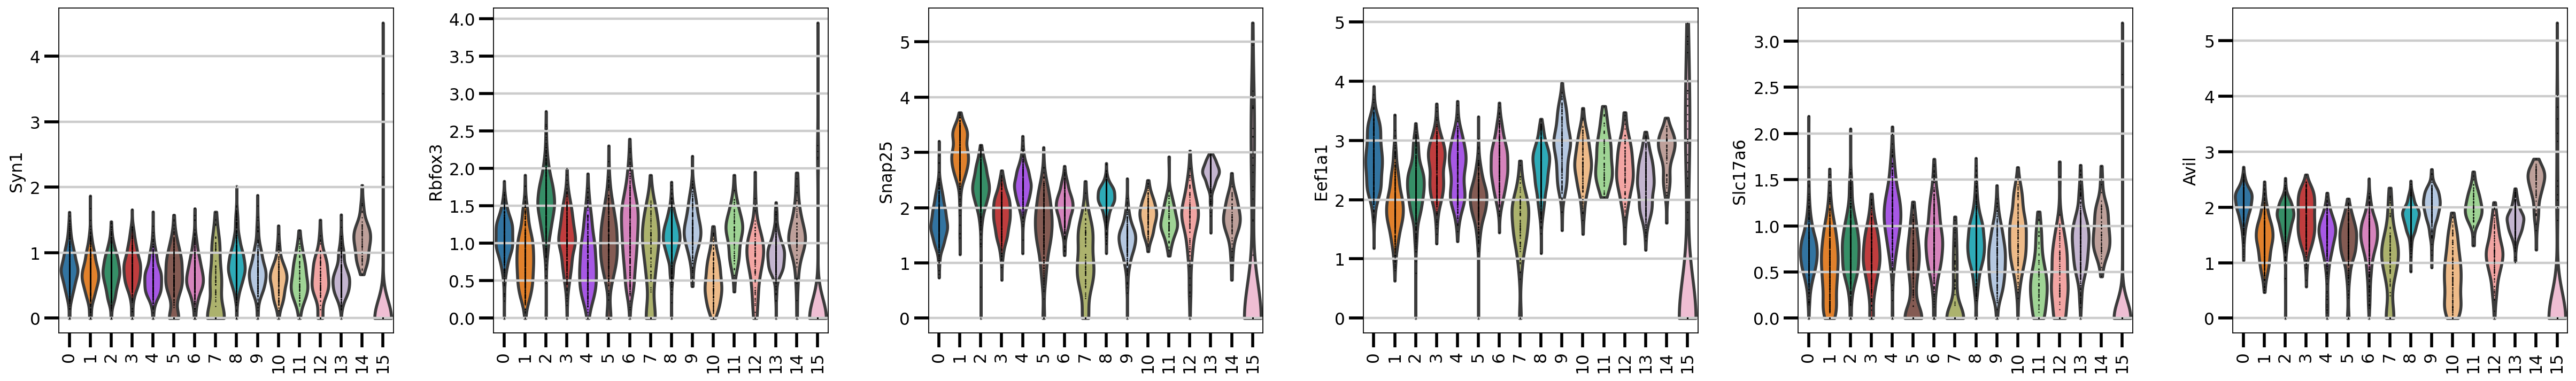

In [27]:
# Assuming you have run Louvain and UMAP already
# Your AnnData object is assumed to be `adata`
# List of genes of interest
genes_of_interest = ['Syn1', 'Rbfox3', 'Snap25', 'Eef1a1', 'Slc17a6', 'Avil']
# Add per-cluster expression by averaging the expression of each gene in the Louvain clusters
sc.tl.rank_genes_groups(adata_concat, clustering_method, method='logreg')
# Create violin plots for the expression of each gene across clusters
sc.pl.violin(adata_concat, genes_of_interest, groupby=clustering_method, jitter=False, rotation=90)

In [28]:
# Calculate the root of the sum of squared values (Euclidean norm) for each gene in all cells
# Convert the sparse matrix to a dense format if necessary and then perform the square and sum
X_dense = adata[:, genes_of_interest].X.toarray()  # Convert to dense array
total_expression = np.sqrt(np.square(X_dense).sum(axis=0))
print(total_expression)
# Calculate the 10% threshold for each gene
thresholds = {gene: 0.025 * total_expression[i] for i, gene in enumerate(genes_of_interest)}
# Print the thresholds for reference
print("Thresholds set to 10% of total expression for each gene:")
for gene, threshold in thresholds.items():
    print(f"{gene}: {threshold}")

[64.58989204 64.86139067 64.86139067 64.86139067 64.86139067 64.86139067]
Thresholds set to 10% of total expression for each gene:
Syn1: 1.6147473010725648
Rbfox3: 1.6215347668181526
Snap25: 1.6215347668181526
Eef1a1: 1.6215347668181526
Slc17a6: 1.6215347668181526
Avil: 1.6215347668181526


In [30]:
# Get the mean expression of the genes in each cluster
mean_expression_per_cluster = adata_concat.raw.to_adata().to_df().groupby(adata_concat.obs[clustering_method]).mean()

# Filter clusters based on thresholds
clusters_to_exclude = []

# Iterate through clusters and check if all gene expressions are below the threshold
for cluster in mean_expression_per_cluster.index:
    all_below_threshold = True  # Start by assuming all genes are below the threshold
    for gene in genes_of_interest:
        if mean_expression_per_cluster.loc[cluster, gene] >= thresholds[gene]:
            all_below_threshold = False  # If any gene is above the threshold, this cluster is not excluded
            break
    if all_below_threshold:
        clusters_to_exclude.append(cluster)

print(f"Clusters to exclude based on low expression of all genes: {clusters_to_exclude}")

Clusters to exclude based on low expression of all genes: ['7', '15']


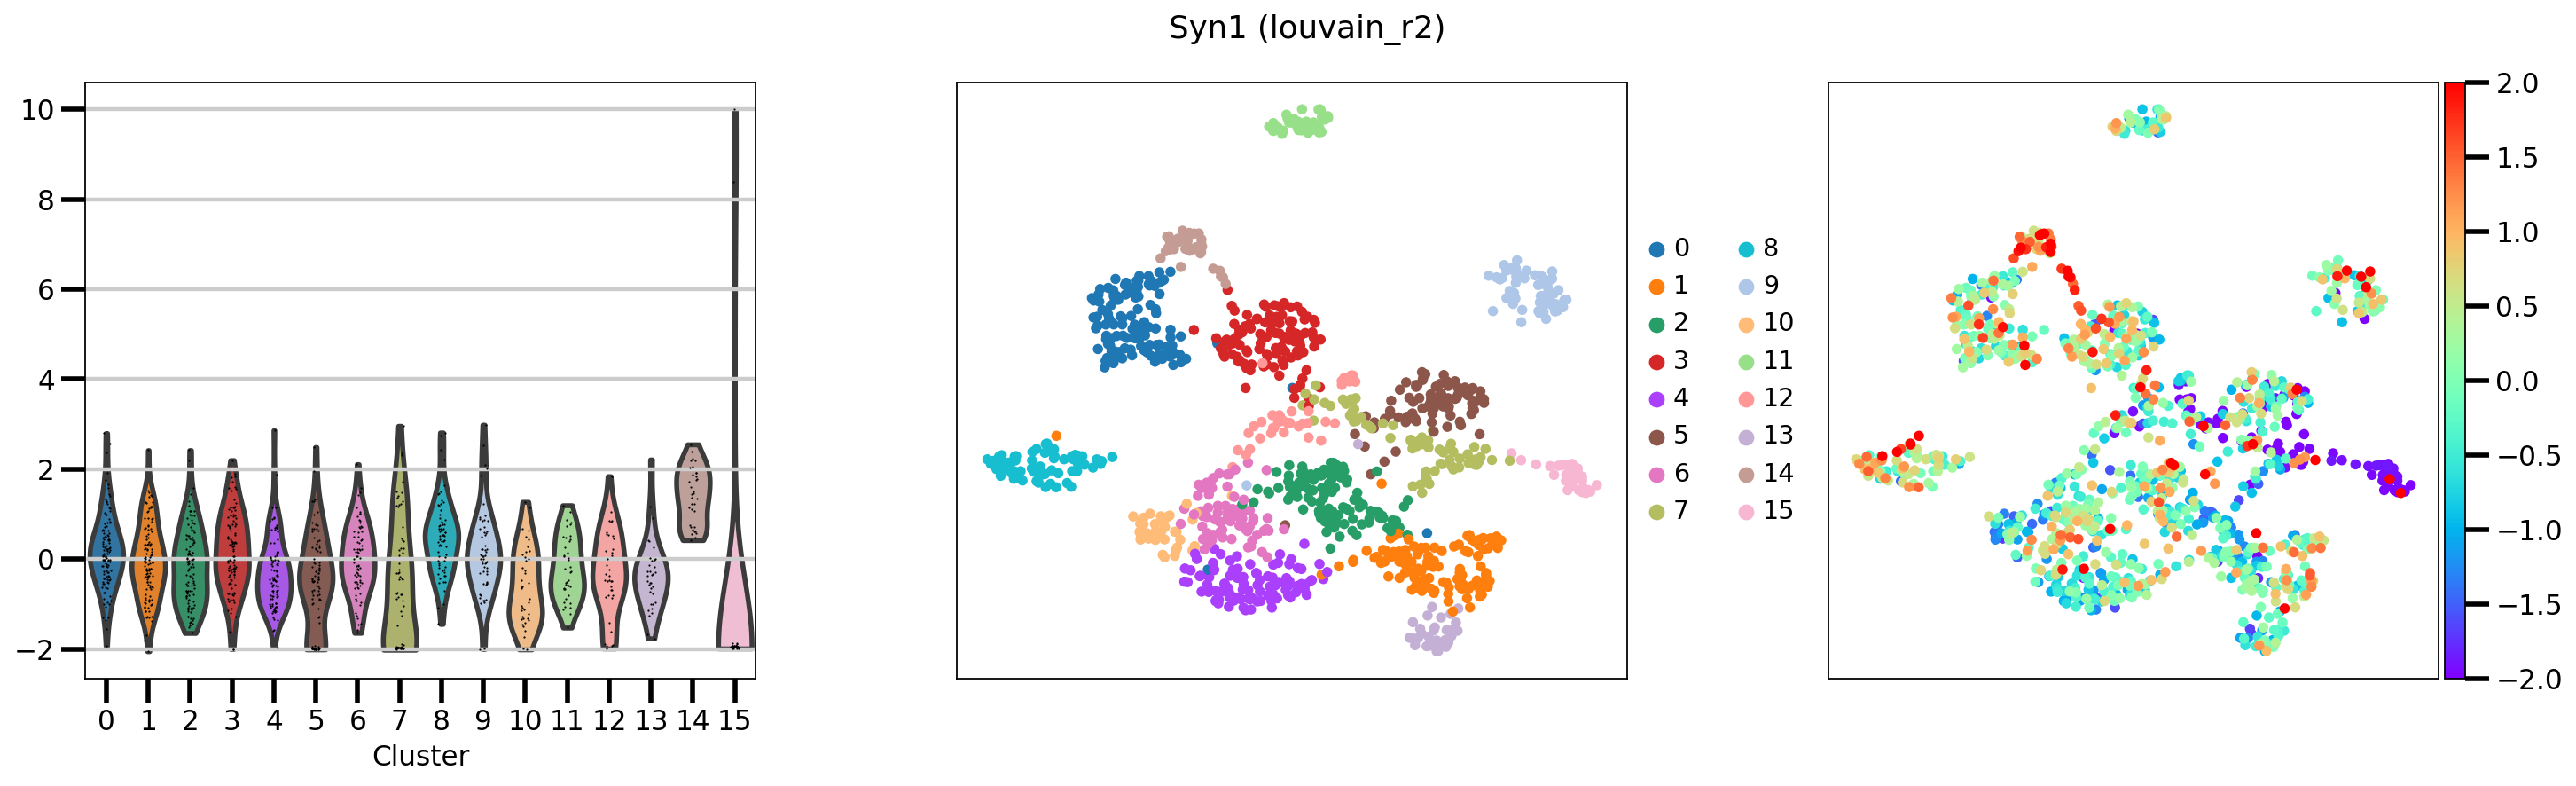

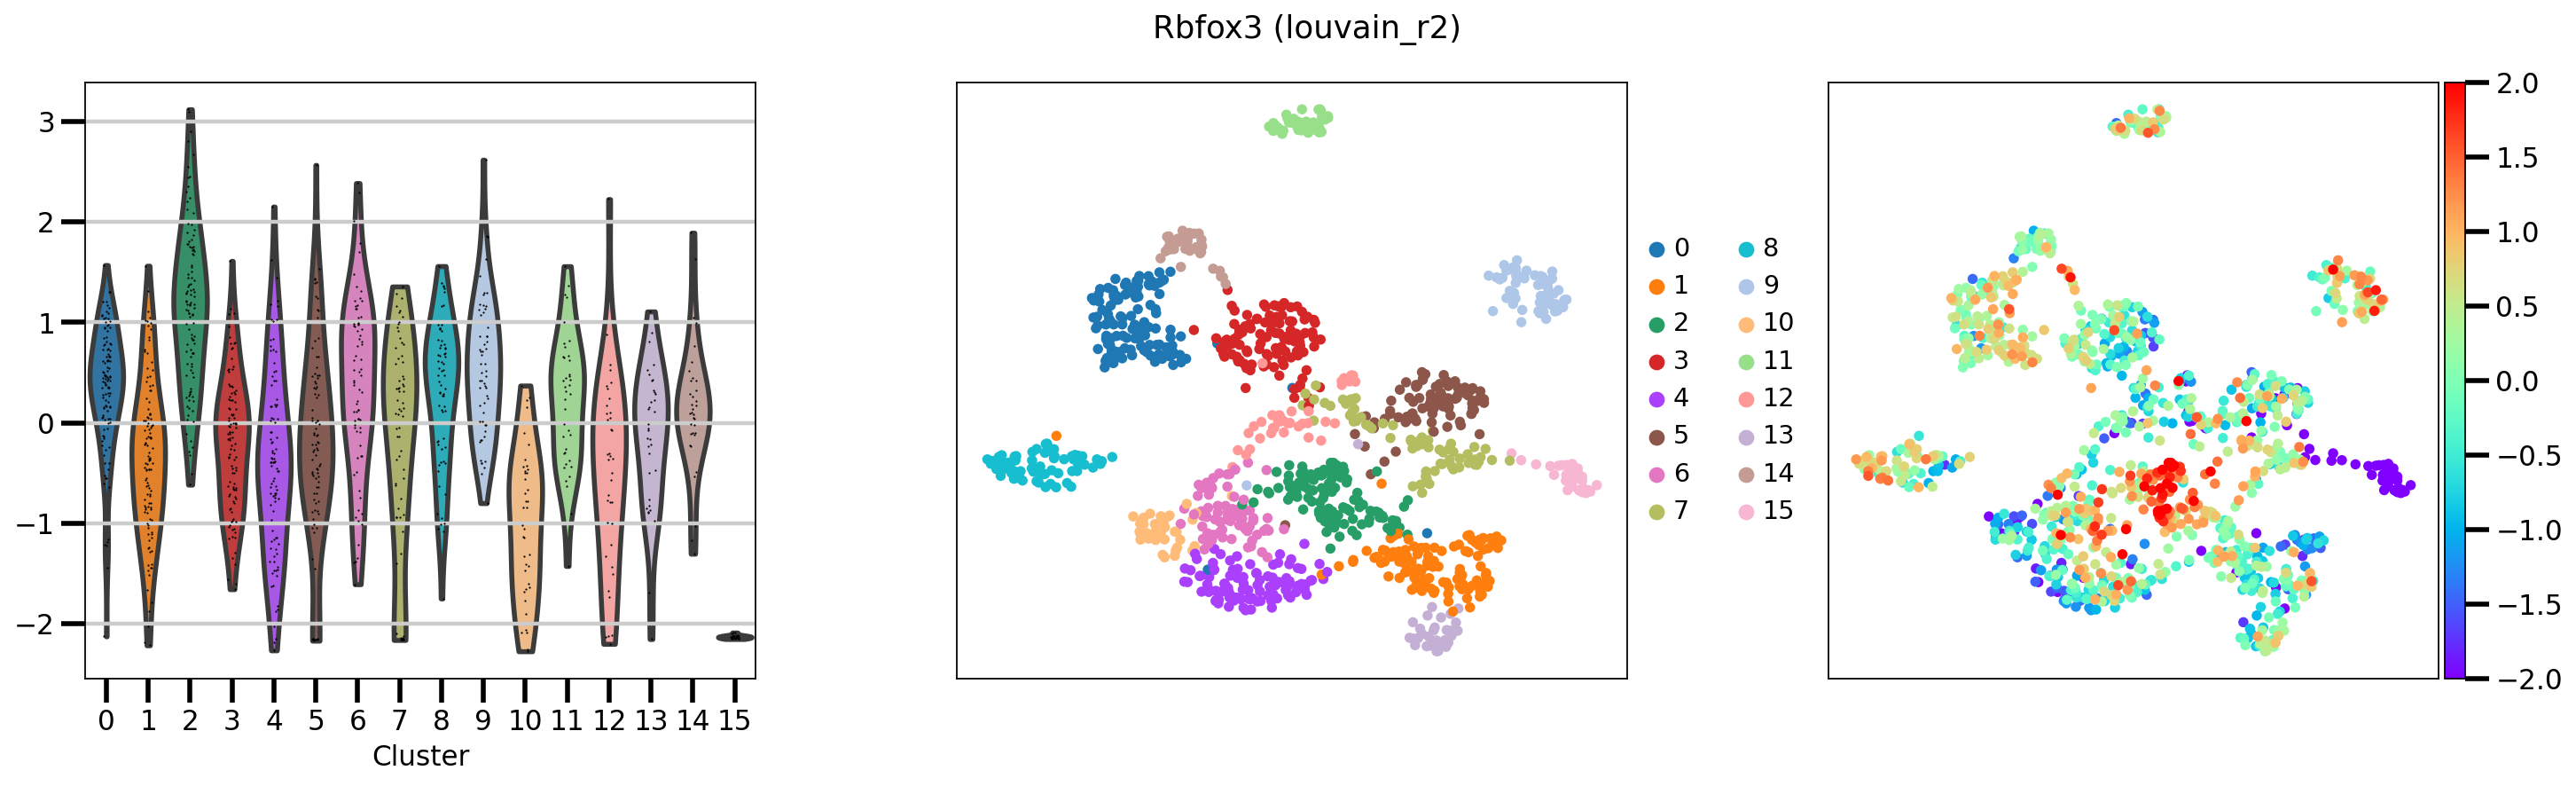

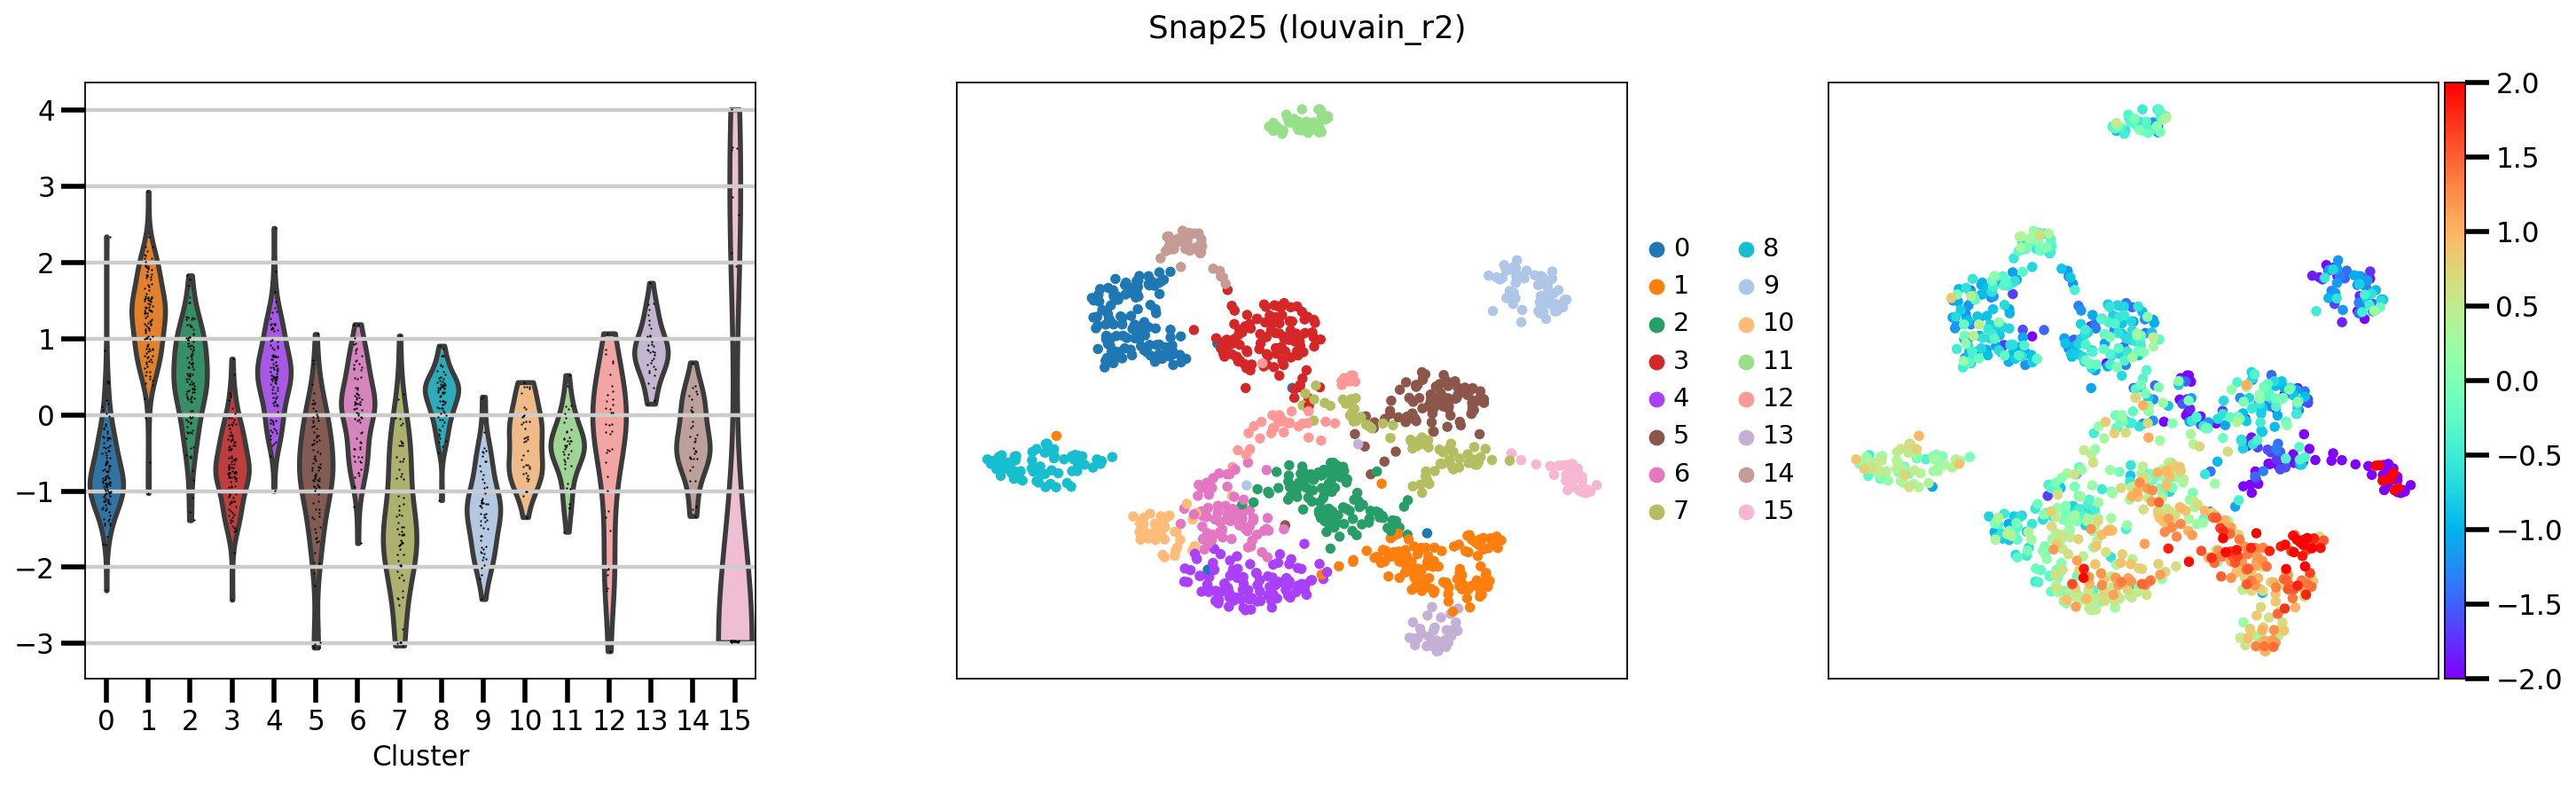

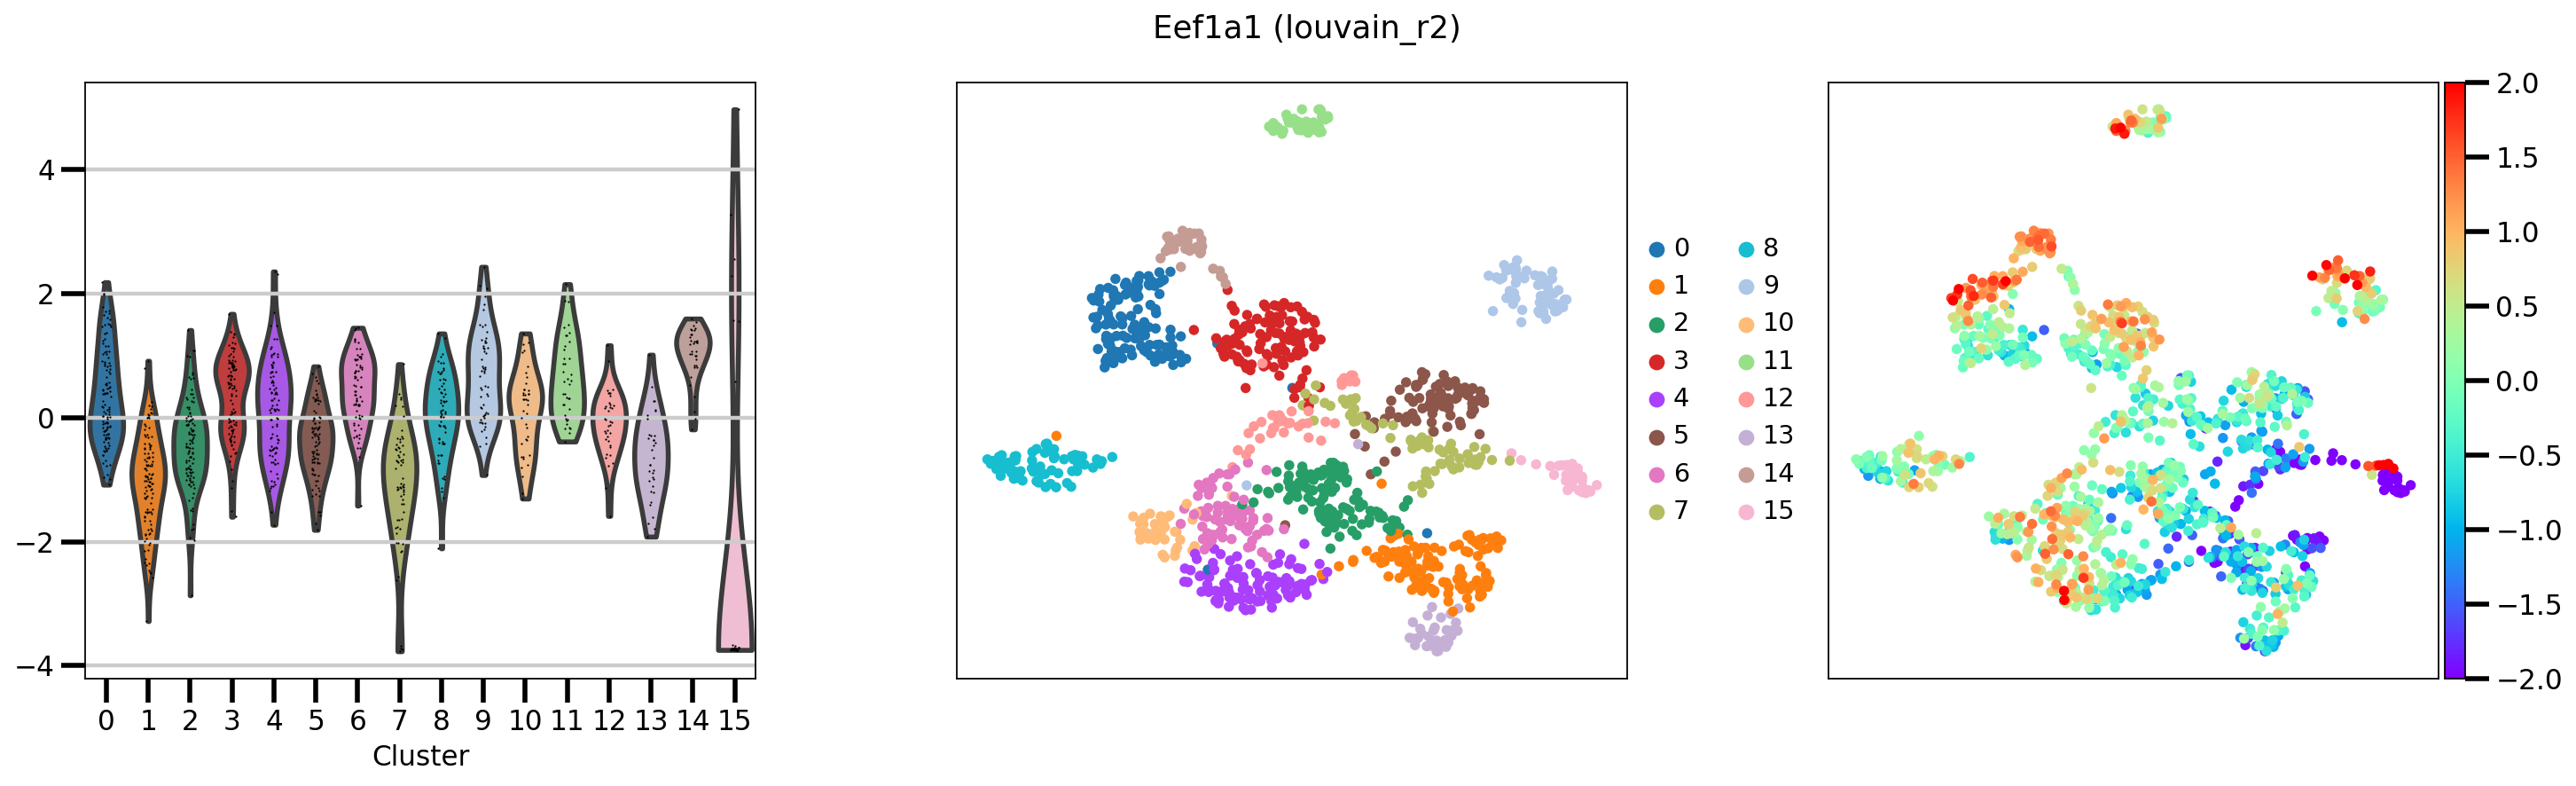

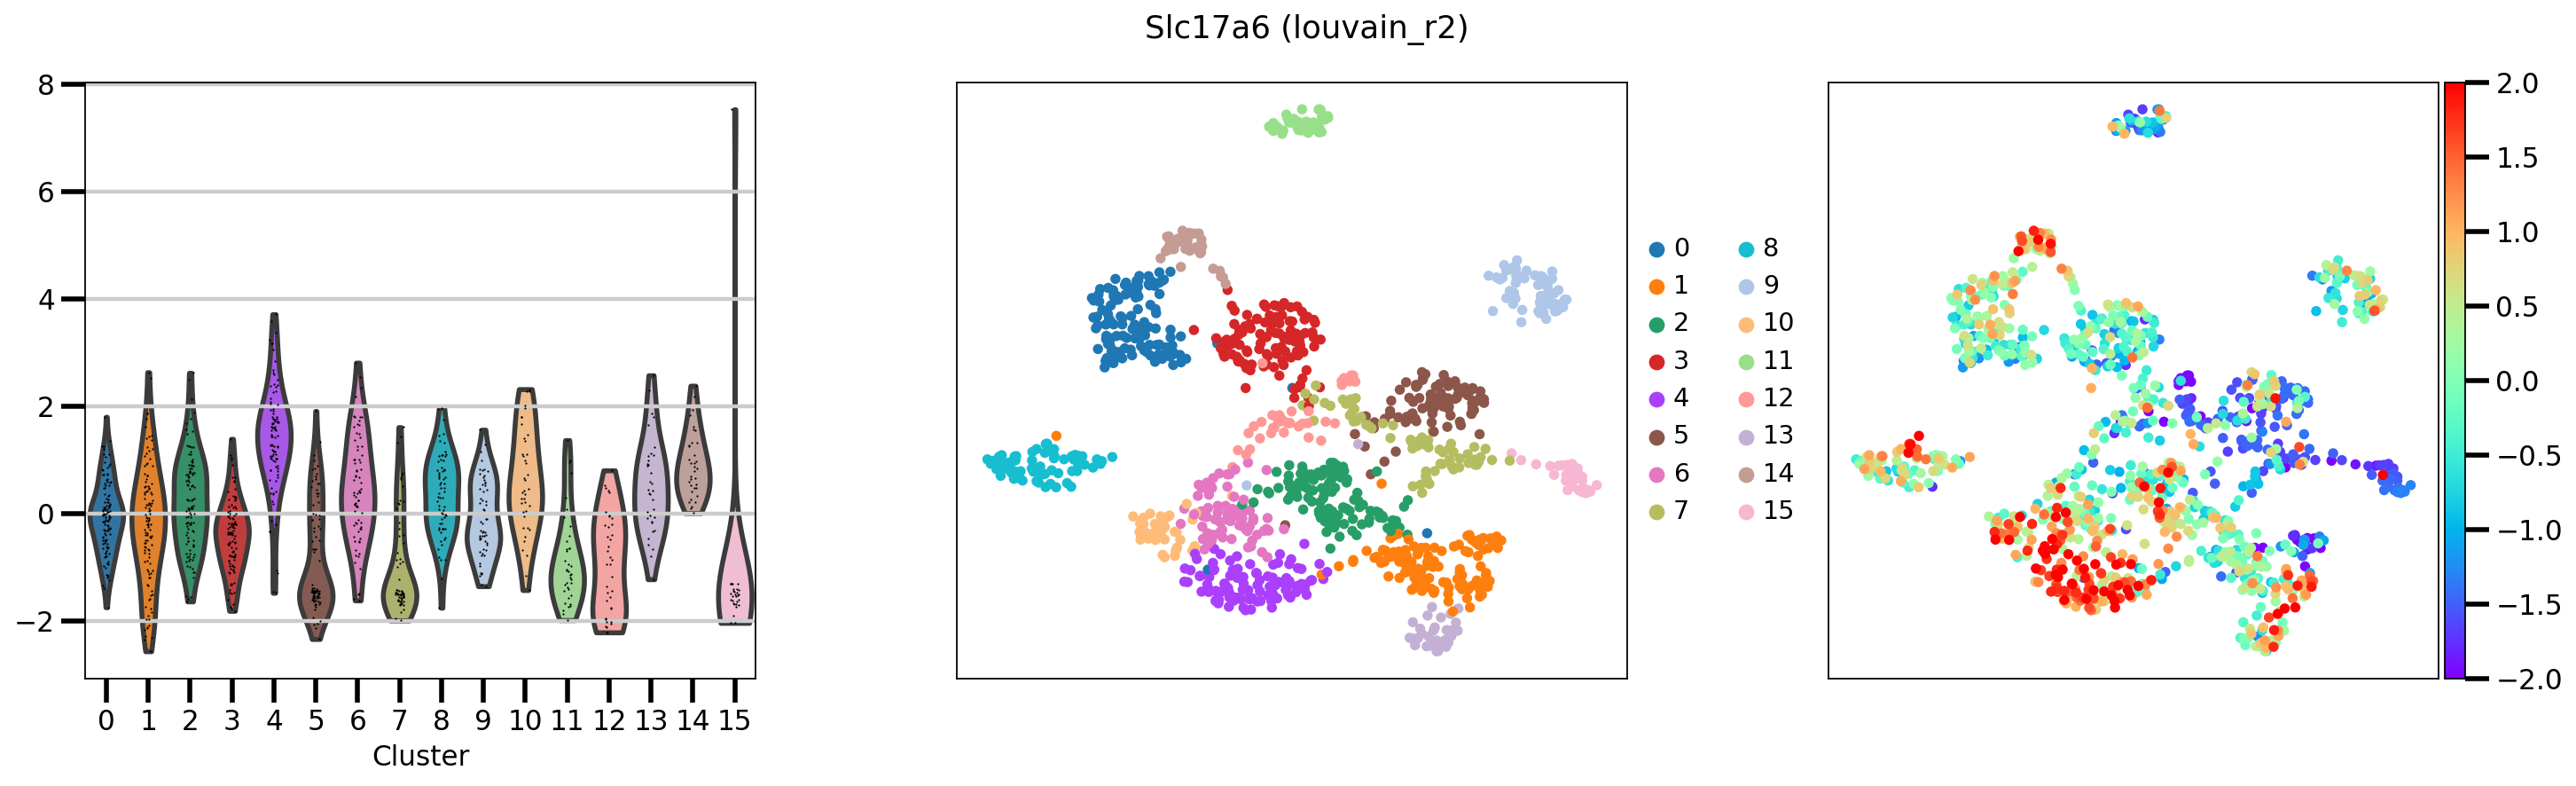

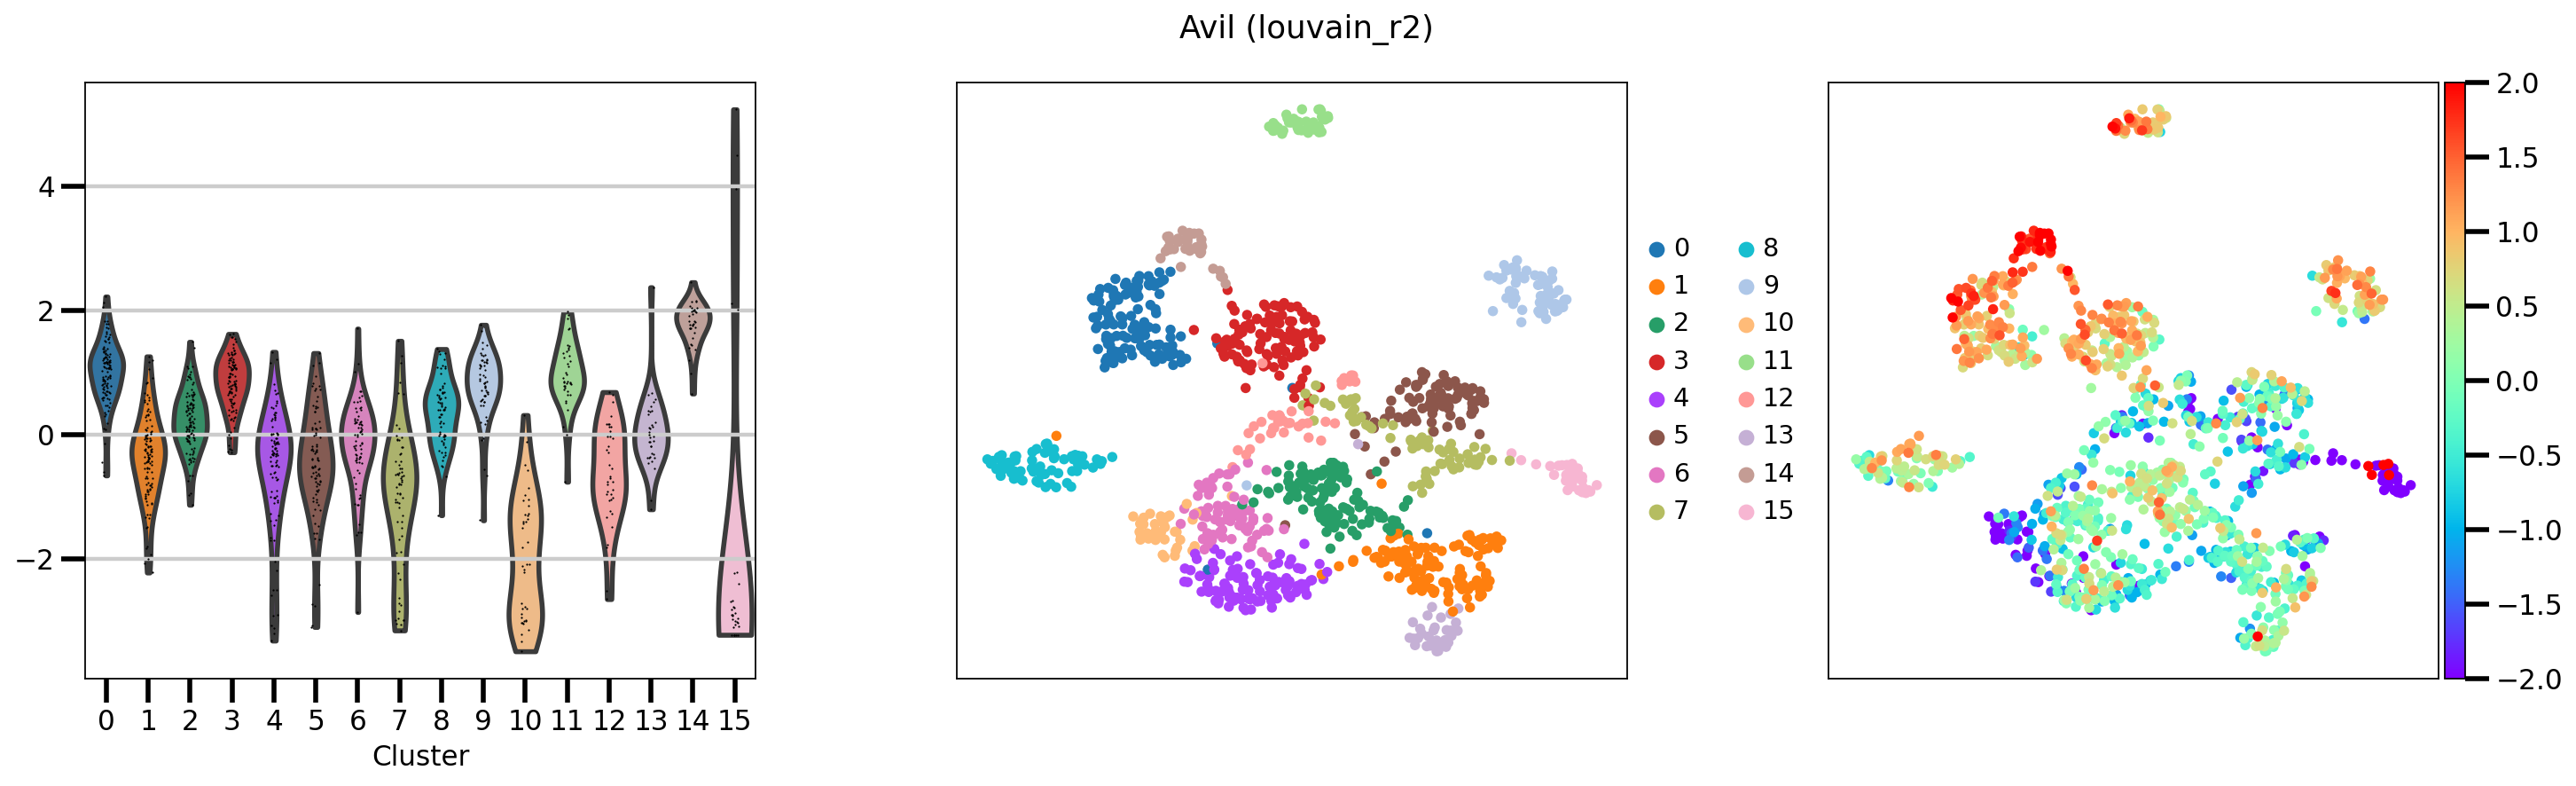

In [33]:
marker_genes = genes_of_interest
for gene in marker_genes:
    # This produces two Axes objects in a single Figure
    ncols=3
    nrows=1
    figsize=5
    wspace=0.2
    fig,ax = plt.subplots(nrows=nrows, ncols=ncols,
                        figsize=(ncols*figsize+figsize*wspace*(ncols-1)+4,nrows*figsize+1))
    plt.subplots_adjust(left=MY_LEFT, 
                    bottom=MY_BOTTOM,  
                    right=MY_RIGHT,  
                    top=MY_TOP,  
                    wspace=MY_WSPACE,  
                    hspace=MY_HSPACE)
    fig.suptitle(gene+' ('+clustering_method+')\n', fontsize=16)
    # We can use these Axes objects individually to plot on them
    # We need to set show=False so that the Figure is not displayed before we
    # finished plotting on all Axes and making all plot adjustments
    sc.pl.violin(adata_control, gene, use_raw=False, groupby=clustering_method,xlabel='Claster', ylabel='',ax=ax[0],show=False)
    ax[0].set_xlabel("Cluster") # change x label from louvain to claster
    ax[0].set_ylabel("")
    sc.pl.umap(adata_control, color=clustering_method, use_raw=False, title='', ax=ax[1],show=False)
    ax[1].set_xlabel("")
    ax[1].set_ylabel("")
    sc.pl.umap(adata_control, color=gene, use_raw=False, cmap = 'rainbow',title='', ax=ax[2],show=False,vmin=-2, vmax=2)
    ax[2].set_xlabel("")
    ax[2].set_ylabel("")
    ax[2].set_xticks([])
    ax[2].set_yticks([]) 
    plt.show()
    fig.savefig(os.path.join(figure_path , 'violin_'+gene+'_'+clustering_method+'.png'))

In [34]:
# Assuming clusters_to_exclude has already been computed from the previous step

# Find the cells that belong to the clusters to exclude
cells_to_exclude = adata_concat.obs[clustering_method].isin(clusters_to_exclude)

# Subset the adata object to exclude those cells
adata_filtered = adata_concat[~cells_to_exclude].copy()
adata_all_filtered = adata_all_concat[~cells_to_exclude].copy()

# Now `adata_filtered` contains only the cells that do not belong to the excluded clusters

print(f"Number of cells before exclusion: {adata_concat.shape[0]}")
print(f"Number of cells after exclusion: {adata_filtered.shape[0]}")


Number of cells before exclusion: 4208
Number of cells after exclusion: 4033


In [35]:
!pip install hdf5plugin
import hdf5plugin
adata_filtered.write_h5ad(
    os.path.join(input_path , 'campari_scs_umap_cells_excluded.h5ad'),
#    compression=hdf5plugin.FILTERS["zstd"],
#    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)
adata_all_filtered.write_h5ad(
    os.path.join(input_path , 'campari_scs_umap_all_cells_excluded.h5ad'),
#    compression=hdf5plugin.FILTERS["zstd"],
#    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)